In [30]:
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense, LSTM
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [31]:
df = pd.read_csv("/content/D202.csv", parse_dates=['DATE'])
df.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,2016-10-22,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,2016-10-22,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,2016-10-22,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,2016-10-22,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,2016-10-22,1:00,1:14,0.01,kWh,$0.00,NaN


In [32]:
print("Row : {}, Cols : {}".format(df.shape[0], df.shape[1]))

Row : 70368, Cols : 8


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   TYPE        70368 non-null  object        
 1   DATE        70368 non-null  datetime64[ns]
 2   START TIME  70368 non-null  object        
 3   END TIME    70368 non-null  object        
 4   USAGE       70368 non-null  float64       
 5   UNITS       70368 non-null  object        
 6   COST        70368 non-null  object        
 7   NOTES       0 non-null      float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 4.3+ MB


In [34]:
df.isnull().sum()

TYPE              0
DATE              0
START TIME        0
END TIME          0
USAGE             0
UNITS             0
COST              0
NOTES         70368
dtype: int64

In [35]:
dates = df['DATE'].values
value = df['USAGE'].values

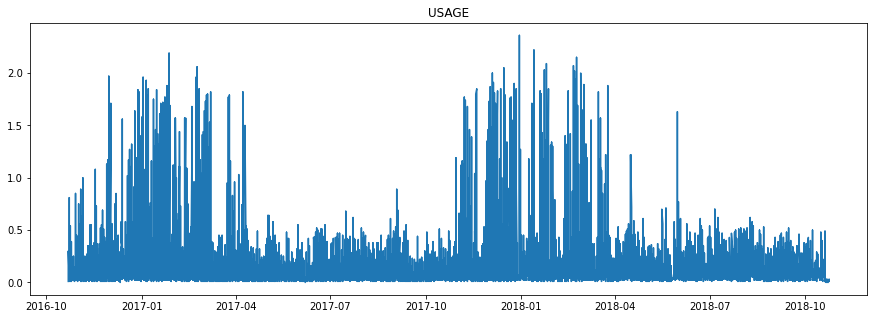

In [36]:
plt.figure(figsize=(15,5))
plt.plot(dates, value)
plt.title("USAGE")
plt.show()

In [37]:
scaler = MinMaxScaler(feature_range=(0,1))
value_scaled = scaler.fit_transform(value.reshape(-1, 1))
value_scaled

array([[0.00423729],
       [0.00423729],
       [0.00423729],
       ...,
       [0.01271186],
       [0.01271186],
       [0.01271186]])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(value_scaled, dates, test_size=0.2, shuffle=False, random_state=42)

In [39]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [40]:
train_set = windowed_dataset(X_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(X_test, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True), input_shape=(None, 1)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60)),
  tf.keras.layers.Dense(120, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(120, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

skala = max(value_scaled) - min(value_scaled)
minMae = skala * 10/100
print(minMae)

[0.1]


In [41]:
optimizer = tf.keras.optimizers.SGD(lr=1e-0002, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,
                    epochs=25,
                    validation_data=test_set)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


563/563 [==============================] - 41s 32ms/step - loss: 0.0045 - mae: 0.0522 - val_loss: 9.5083e-04 - val_mae: 0.0279
Epoch 2/25
563/563 [==============================] - 17s 30ms/step - loss: 0.0045 - mae: 0.0522 - val_loss: 9.4290e-04 - val_mae: 0.0284
Epoch 3/25
563/563 [==============================] - 18s 32ms/step - loss: 0.0045 - mae: 0.0522 - val_loss: 9.5466e-04 - val_mae: 0.0277
Epoch 4/25
563/563 [==============================] - 17s 30ms/step - loss: 0.0045 - mae: 0.0522 - val_loss: 9.5621e-04 - val_mae: 0.0277
Epoch 5/25
563/563 [==============================] - 17s 30ms/step - loss: 0.0045 - mae: 0.0522 - val_loss: 9.5711e-04 - val_mae: 0.0276
Epoch 6/25
563/563 [==============================] - 17s 30ms/step - loss: 0.0045 - mae: 0.0522 - val_loss: 9.5108e-04 - val_mae: 0.0279
Epoch 7/25
563/563 [==============================] - 17s 30ms/step - loss: 0.0045 - mae: 0.0521 - val_loss: 9.5063e-04 - val_mae: 0.0280
Epoch 8/25
563/563 [=========================

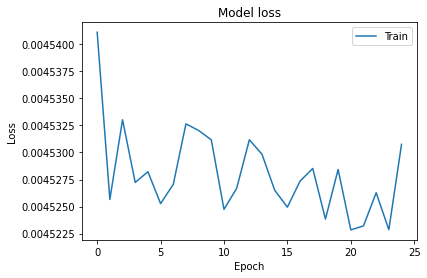

In [44]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

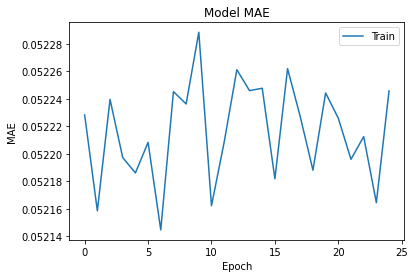

In [45]:
plt.plot(history.history['mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()